## Trading System Project
### Extension of  Chapter 5, case study 1 in Machine Learning and Data Science Blueprints for finance by Tatsat
### Predicts the weekly return of Micron Technology (NASDAQ: MU) using different models



### Import Dependencies

In [291]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.linear_model import BayesianRidge

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


import statsmodels.api as sm

# pandas, pandas_datareader, numpy and matplotlib
import numpy as np
import pandas as pd
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from pandas.plotting import scatter_matrix
from scipy.stats import norm, spearmanr
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.pipeline import Pipeline

from matplotlib import pyplot
import matplotlib.dates as mdates

import yfinance as yf
import talib as ta
import xgboost as xgb
import fAux
import detrendPrice

from pycaret.regression import RegressionExperiment
from pycaret.time_series import TSForecastingExperiment

np.random.seed(123)

### Download data

In [228]:
stk_tickers = ['NVDA', 'AMD', 'MU', "WDC", "STX", "QCOM"]
etf_tickers = ["QQQ", "VGT", "SOXX"]
idx_tickers = ['^GSPC', '^DJI', '^IXIC']

for tic in stk_tickers + etf_tickers + idx_tickers:

    data = yf.download(tic, end="2020-01-01", start="2010-01-01")
    data.to_csv(f"data/{tic}.csv")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


#### Load data from file

In [229]:
df_mapping = {}
for tic in stk_tickers + etf_tickers + idx_tickers:
    df = pd.read_csv(f"data/{tic}.csv")
    df = df.set_index("Date")
    df_mapping[tic] = df

stk_dfs = [df_mapping[s] for s in stk_tickers]
etf_dfs = [df_mapping[s] for s in etf_tickers]
idx_dfs = [df_mapping[s] for s in idx_tickers]
stk_combined = pd.concat(stk_dfs, axis=1, keys=stk_tickers).swaplevel(0,1,axis=1).sort_index(axis=1)
etf_combined = pd.concat(etf_dfs, axis=1, keys=etf_tickers).swaplevel(0,1,axis=1).sort_index(axis=1)
idx_combined = pd.concat(idx_dfs, axis=1, keys=idx_tickers).swaplevel(0,1,axis=1).sort_index(axis=1)

stk_combined

Adj Close                                                         \
                  AMD         MU       NVDA       QCOM        STX        WDC   
Date                                                                           
2010-01-04   9.700000  10.656092   4.240229  32.535530  10.182711  36.334633   
2010-01-05   9.710000  10.970372   4.302146  33.318760   9.983257  37.297989   
2010-01-06   9.570000  11.019479   4.329666  32.992989   9.913178  37.330109   
2010-01-07   9.470000  10.646270   4.244815  33.949516   9.724513  36.599560   
2010-01-08   9.430000  10.901623   4.253989  34.289150   9.643653  36.784203   
...               ...        ...        ...        ...        ...        ...   
2019-12-24  46.540001  54.429543  59.420006  80.613503  49.895432  60.941479   
2019-12-26  46.630001  54.125080  59.561951  80.277496  50.256081  61.499676   
2019-12-27  46.180000  53.064384  58.984230  80.640762  49.970917  60.843552   
2019-12-30  45.520000  52.259041  57.851215  80.304741  49.727692  61.088375   
2019-12-31  45.860001  52.818851  58.593285  80.123123  49.903831  62.155804   

                Close                                   ...       Open  \
                  AMD         MU       NVDA       QCOM  ...       NVDA   
Date                                                    ...              
2010-01-04   9.700000  10.850000   4.622500  46.939999  ...   4.627500   
2010-01-05   9.710000  11.170000   4.690000  48.070000  ...   4.605000   
2010-01-06   9.570000  11.220000   4.720000  47.599998  ...   4.687500   
2010-01-07   9.470000  10.840000   4.627500  48.980000  ...   4.695000   
2010-01-08   9.430000  11.100000   4.637500  49.470001  ...   4.590000   
...               ...        ...        ...        ...  ...        ...   
2019-12-24  46.540001  55.419998  59.654999  88.769997  ...  59.549999   
2019-12-26  46.630001  55.110001  59.797501  88.400002  ...  59.689999   
2019-12-27  46.180000  54.029999  59.217499  88.800003  ...  59.950001   
2019-12-30  45.520000  53.209999  58.080002  88.430000  ...  58.997501   
2019-12-31  45.860001  53.779999  58.825001  88.230003  ...  57.724998   

                                               Volume                      \
                 QCOM        STX        WDC       AMD        MU      NVDA   
Date                                                                        
2010-01-04  46.790001  18.570000  44.400002  18748700  34412700  80020400   
2010-01-05  47.520000  18.860001  45.349998  22145700  60659000  72864800   
2010-01-06  48.259998  18.430000  46.540001  18643400  32060400  64916800   
2010-01-07  47.750000  18.400000  46.400002  26806800  46461800  54779200   
2010-01-08  49.110001  17.580000  45.490002  13752800  32433400  47816800   
...               ...        ...        ...       ...       ...       ...   
2019-12-24  88.620003  59.880001  62.740002  44432200   8621900  13886400   
2019-12-26  88.919998  59.529999  62.119999  57562800  13537400  18285200   
2019-12-27  88.900002  60.000000  63.099998  36581300  17176700  25464400   
2019-12-30  88.709999  59.599998  62.000000  41149700  15271500  25805600   
2019-12-31  87.989998  59.150002  61.910000  31673200  13296400  23100400   

                                         
                QCOM       STX      WDC  
Date                                     
2010-01-04  14570200  11116900  3118200  
2010-01-05  24241000  14536200  7048900  
2010-01-06  22743800   7171200  3996100  
2010-01-07  25266300   8556300  3626500  
2010-01-08  25938200  11329000  2521700  
...              ...       ...      ...  
2019-12-24   2435200    820000  1932900  
2019-12-26   5070000   1071000  2323300  
2019-12-27   5808900   1298100  3178700  
2019-12-30   6543100   1060300  3250100  
2019-12-31   5173400   1266200  3850300  

[2516 rows x 36 columns]

### Calculate Lag

In [230]:
return_period = 5

Y = (np.log(stk_combined.loc[:, ("Adj Close", "MU")])
    .diff(return_period)
    .shift(-return_period))
Y.name = Y.name[-1] + "_pred"
X1 = np.log(stk_combined.loc[:, ("Adj Close", ("NVDA", "AMD", "WDC", "STX", "QCOM"))]).diff(return_period)
X1.columns = X1.columns.droplevel()
X2 = np.log(etf_combined.loc[:, ("Adj Close", etf_tickers)]).diff(return_period)
X2.columns = X2.columns.droplevel()
X3 = np.log(idx_combined.loc[:, ("Adj Close", idx_tickers)]).diff(return_period)
X3.columns = X3.columns.droplevel()
X4 = pd.concat(
            [np.log(stk_combined.loc[:, ("Adj Close", "MU")]).diff(i)
            for i in [return_period,
                    return_period * 3,
                    return_period * 6,
                    return_period * 12]],
                axis=1).dropna()
X4.columns = ["MU_DT", "MU_3DT", "MU_6DT", "MU_12DT"]
X = pd.concat([X1, X2, X3, X4], axis=1)

### Calculate the indicators with TA-Lib

In [231]:
mu_data = df_mapping["MU"]

# Relative strength index
rsi = ta.RSI(mu_data["Close"].values, timeperiod=return_period)
mu_data["MU_RSI"] = rsi
# Momentum
mom = ta.MOM(mu_data["Close"].values, timeperiod=return_period)
mu_data["MU_MOM"] = mom
# Simple moving average
sma = ta.SMA(mu_data["Close"].values)
mu_data["MU_SMA"] = sma
# rate of change
sma = ta.ROC(mu_data["Close"].values, timeperiod=return_period)
mu_data["MU_ROC"] = sma
# Average directional index
adx = ta.ADX(mu_data["High"].values, mu_data["Low"].values, mu_data["Close"].values, timeperiod=return_period)
mu_data["MU_ADX"] = adx

X = X.join(mu_data.iloc[:,-5:])
X = X.fillna(X.mean())
print(X.shape)


(2516, 20)


In [281]:
dataset = pd.concat([Y, X], axis=1).dropna()
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

### Exploratory Data Analysis

In [233]:

dataset.head(10)

,MU_pred,NVDA,AMD,WDC,STX,QCOM,QQQ,VGT,SOXX,^GSPC,...,^IXIC,MU_DT,MU_3DT,MU_6DT,MU_12DT,MU_RSI,MU_MOM,MU_SMA,MU_ROC,MU_ADX
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,0.004598,0.005223,0.003131,0.001013,0.003225,0.001748,0.003244,0.003152,0.003932,0.002077,...,0.002706,0.003337,0.01003,0.019961,0.039121,52.537390,0.086169,22.372939,0.538852,39.905473
2010-01-05,-0.084979,0.005223,0.003131,0.001013,0.003225,0.001748,0.003244,0.003152,0.003932,0.002077,...,0.002706,0.003337,0.01003,0.019961,0.039121,52.537390,0.086169,22.372939,0.538852,39.905473
2010-01-06,-0.070139,0.005223,0.003131,0.001013,0.003225,0.001748,0.003244,0.003152,0.003932,0.002077,...,0.002706,0.003337,0.01003,0.019961,0.039121,52.537390,0.086169,22.372939,0.538852,39.905473
2010-01-07,-0.010199,0.005223,0.003131,0.001013,0.003225,0.001748,0.003244,0.003152,0.003932,0.002077,...,0.002706,0.003337,0.01003,0.019961,0.039121,52.537390,0.086169,22.372939,0.538852,39.905473
2010-01-08,-0.091444,0.005223,0.003131,0.001013,0.003225,0.001748,0.003244,0.003152,0.003932,0.002077,...,0.002706,0.003337,0.01003,0.019961,0.039121,52.537390,0.086169,22.372939,0.538852,39.905473
2010-01-11,-0.058563,-0.010875,-0.059465,0.013387,-0.029003,0.048851,-0.001293,-0.008458,-0.000602,0.012272,...,0.001727,0.003337,0.01003,0.019961,0.039121,52.066082,0.049999,22.372939,0.460822,39.905473
2010-01-12,-0.027670,-0.059858,-0.115597,-0.038842,-0.044157,0.008700,-0.013883,-0.020664,-0.034560,-0.000264,...,-0.011501,0.003337,0.01003,0.019961,0.039121,31.343286,-0.910000,22.372939,-8.146820,39.905473
2010-01-13,-0.065176,-0.052744,-0.044879,-0.022620,-0.010935,0.022847,0.004541,-0.002714,-0.019956,0.007482,...,0.002955,0.003337,0.01003,0.019961,0.039121,40.581263,-0.760000,22.372939,-6.773620,39.905473
2010-01-14,-0.161478,-0.048709,-0.050904,0.003940,0.016493,-0.012532,0.004754,0.007408,-0.013914,0.005912,...,0.007230,0.003337,0.01003,0.019961,0.039121,51.576271,-0.110001,22.372939,-1.014766,39.905473


In [234]:
dataset.describe()

,MU_pred,NVDA,AMD,WDC,STX,QCOM,QQQ,VGT,SOXX,^GSPC,...,^IXIC,MU_DT,MU_3DT,MU_6DT,MU_12DT,MU_RSI,MU_MOM,MU_SMA,MU_ROC,MU_ADX
count,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,...,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000
mean,0.003173,0.005215,0.003020,0.000909,0.003201,0.001749,0.003227,0.003132,0.003919,0.002066,...,0.002690,0.003340,0.009741,0.019704,0.038735,52.514116,0.086133,22.319176,0.539421,39.871739
std,0.066603,0.056590,0.080655,0.056635,0.060918,0.041641,0.023342,0.024364,0.032449,0.019817,...,0.023144,0.066113,0.109225,0.152734,0.228171,20.641678,1.692946,14.529679,6.635152,14.118803
min,-0.418467,-0.333463,-0.395724,-0.296706,-0.328504,-0.218777,-0.132023,-0.128785,-0.152435,-0.139421,...,-0.151957,-0.418467,-0.435047,-0.494839,-0.688934,2.344387,-9.579998,5.395000,-34.194529,11.322211
25%,-0.037710,-0.024454,-0.039613,-0.031223,-0.028163,-0.016430,-0.008462,-0.009100,-0.014224,-0.006587,...,-0.008734,-0.036316,-0.060398,-0.077194,-0.122049,36.806496,-0.570000,9.184500,-3.700816,29.348098
50%,0.005955,0.005805,0.003795,0.001788,0.005939,0.003879,0.005647,0.005636,0.006722,0.003828,...,0.005215,0.003466,0.010030,0.019961,0.063586,52.483744,0.086169,17.531000,0.586169,37.530889
75%,0.045459,0.037776,0.048408,0.034809,0.035081,0.022156,0.016998,0.017743,0.024993,0.013350,...,0.016753,0.044794,0.082435,0.132189,0.216654,68.269079,0.759999,32.430833,4.650777,48.416022
max,0.236994,0.318561,0.390539,0.229205,0.331403,0.416480,0.089713,0.094454,0.114814,0.083444,...,0.094000,0.236994,0.309491,0.439564,0.495211,96.771606,7.959999,58.557666,26.743390,87.465466


### Sample Distribution

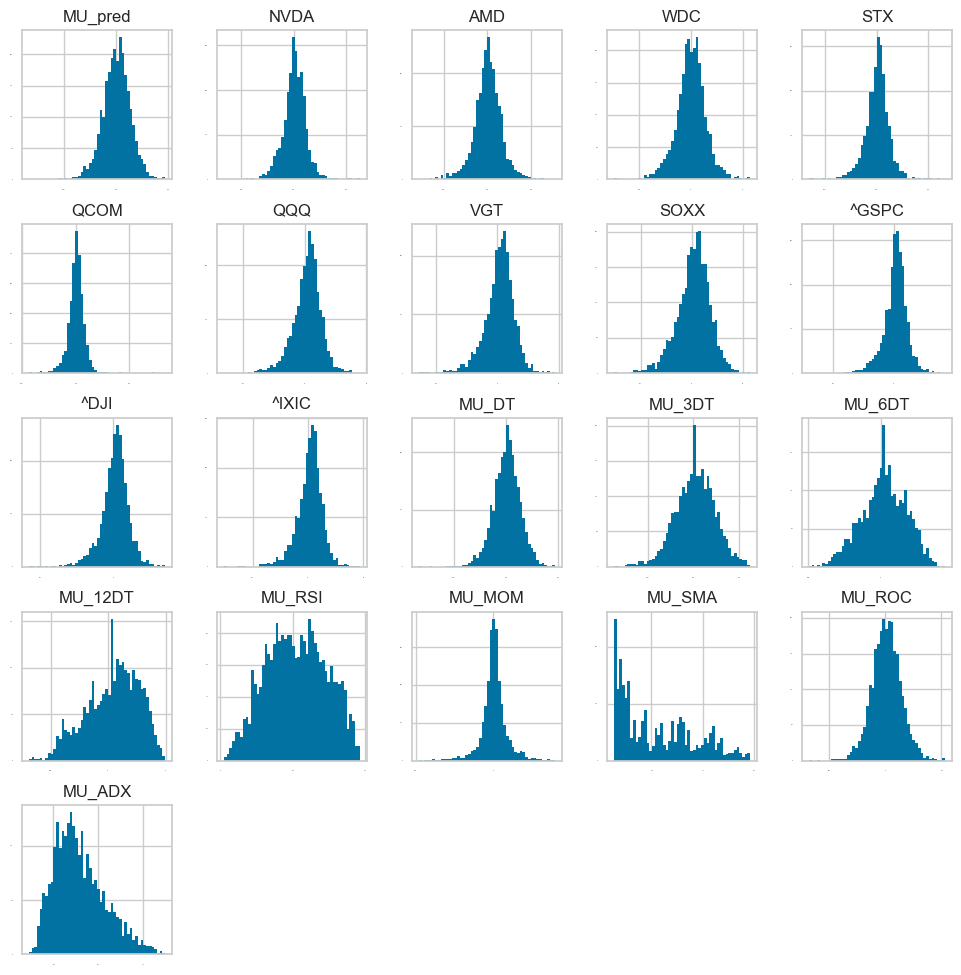

In [235]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

### Density Distribution

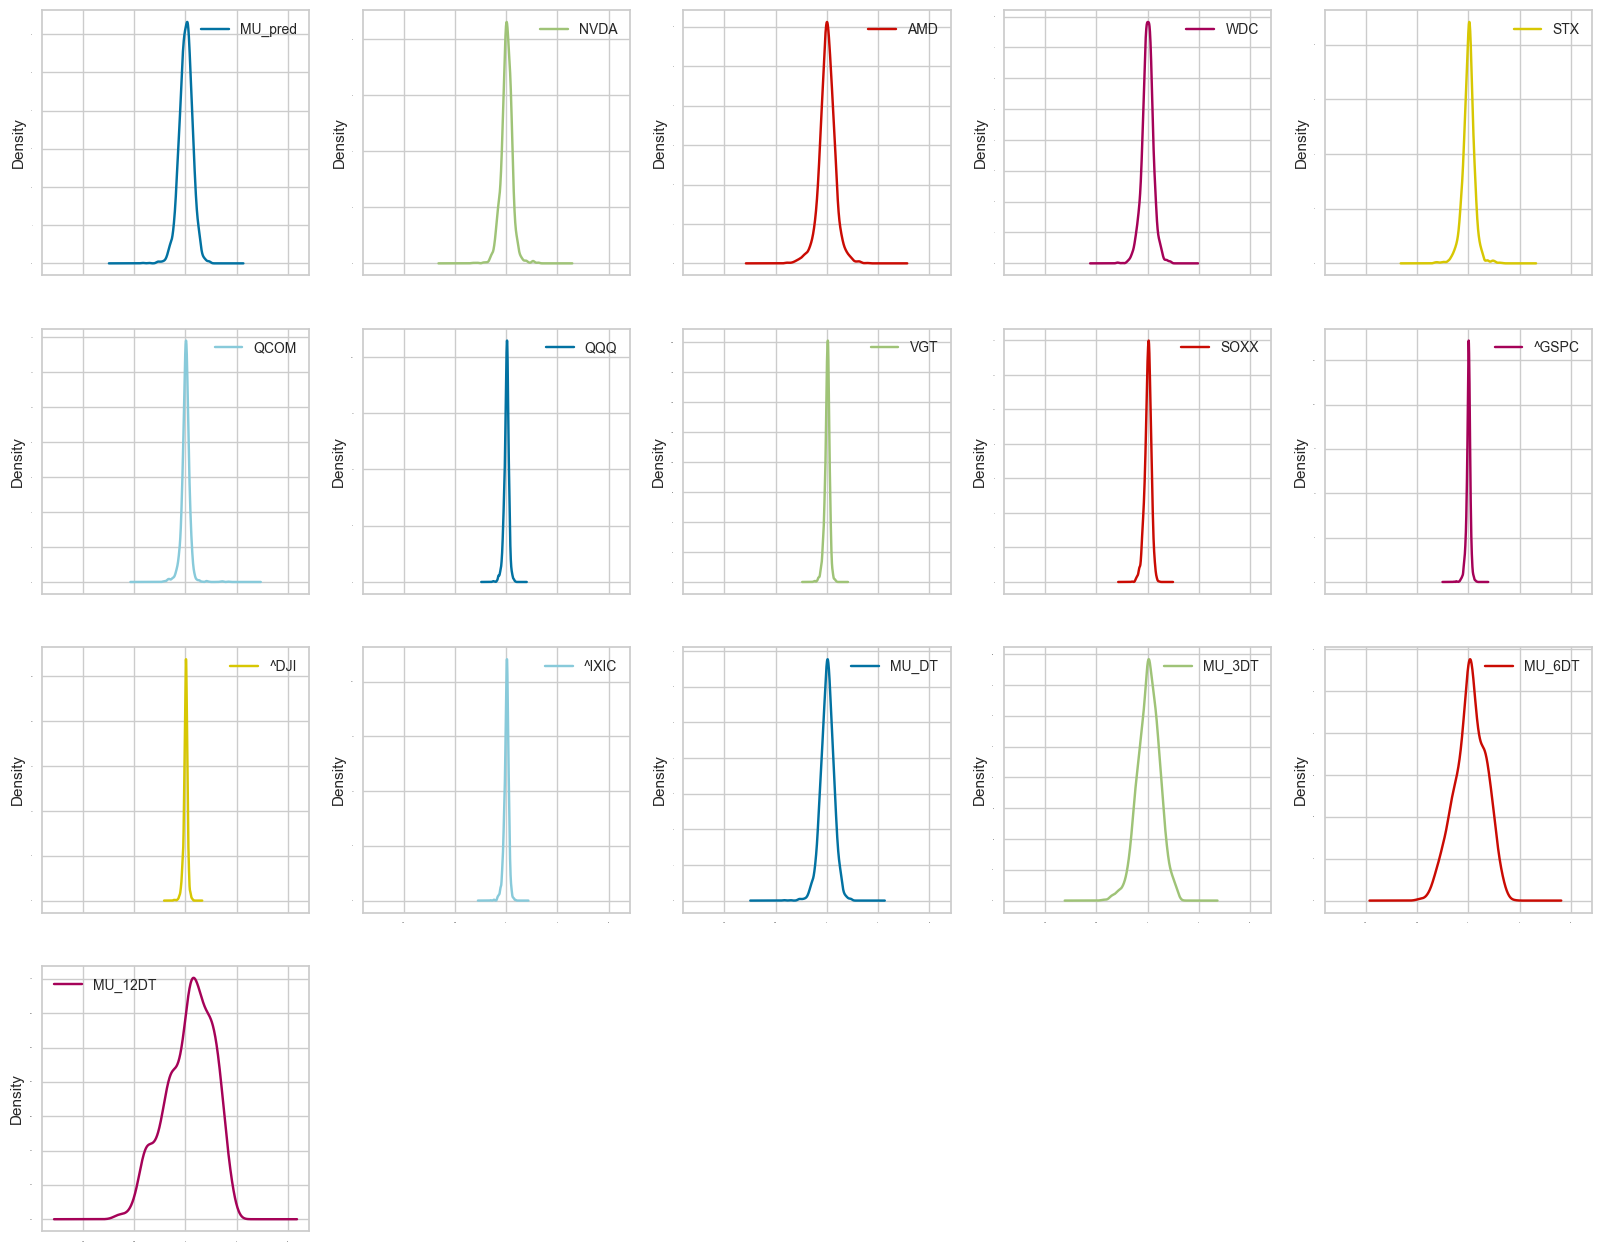

In [283]:
indicator_col = ["MU_RSI", "MU_MOM", "MU_SMA","MU_ROC","MU_ADX"]
dataset = dataset.drop(indicator_col, axis=1)
dataset.plot(kind='density', subplots=True, layout=(5,5), sharex=True, legend=True, fontsize=1, figsize=(20,20))
pyplot.show()

### Correlation analysis

<Axes: title={'center': 'Correlation Matrix'}>

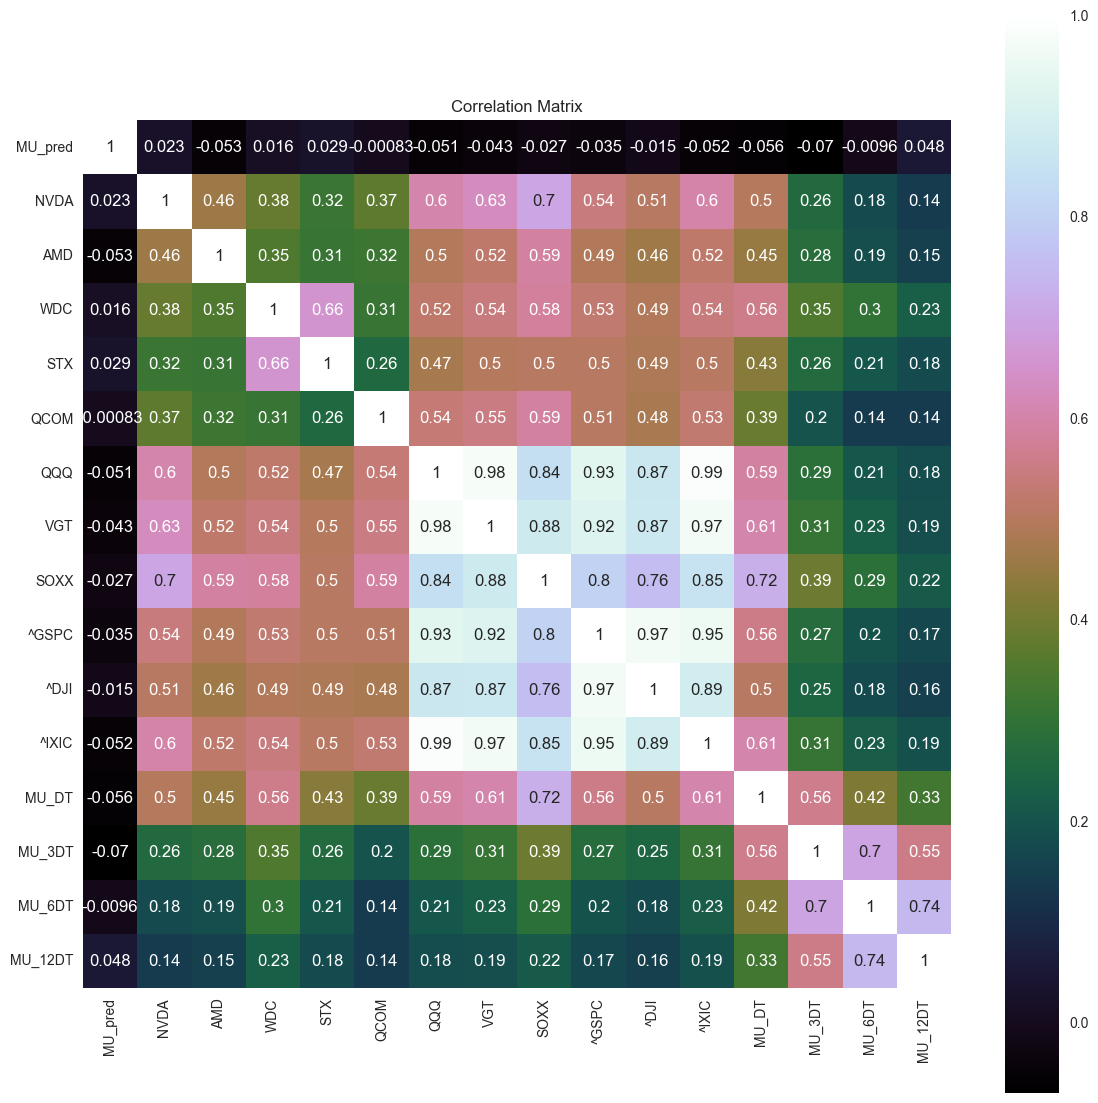

In [237]:
correlation = dataset.corr()
pyplot.figure(figsize=(14,14))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

### Scattered plot

<Figure size 1400x1400 with 0 Axes>

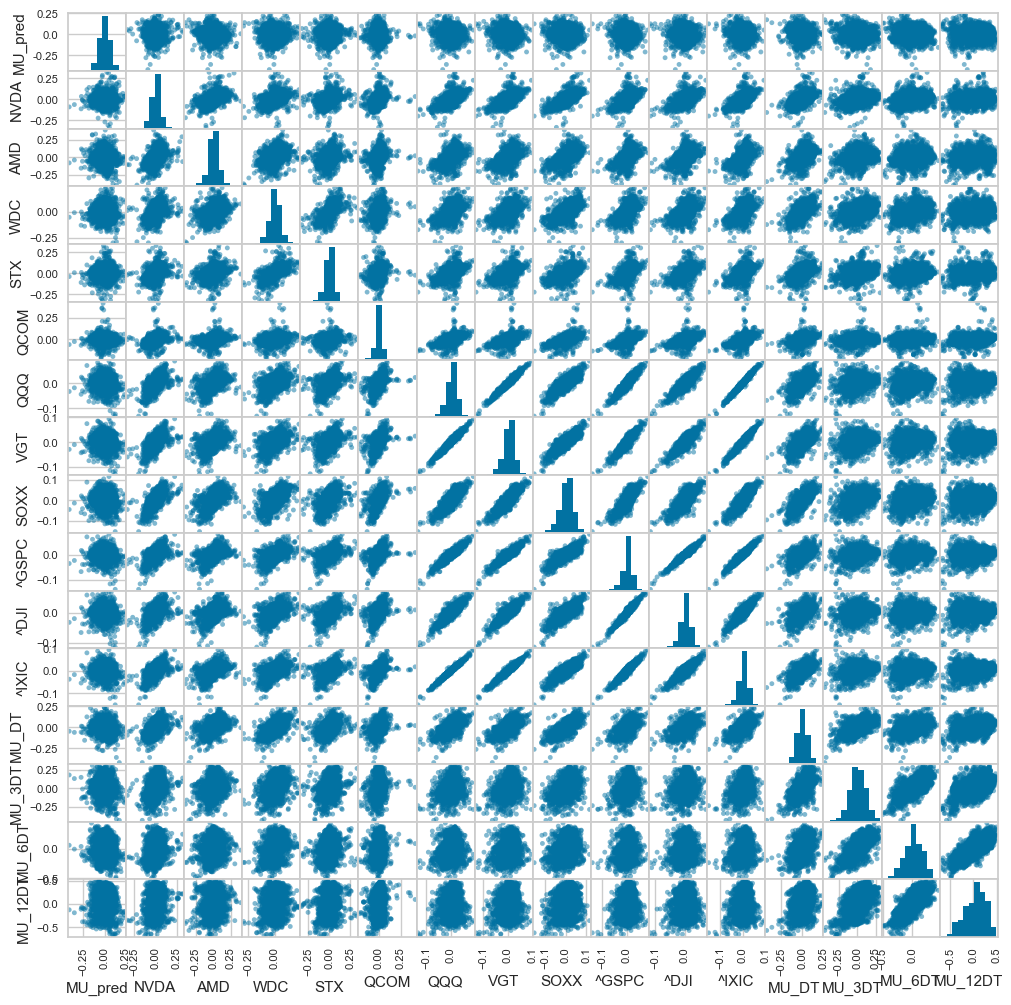

In [238]:
pyplot.figure(figsize=(14,14))
scatter_matrix(dataset,figsize=(12,12))
pyplot.show()

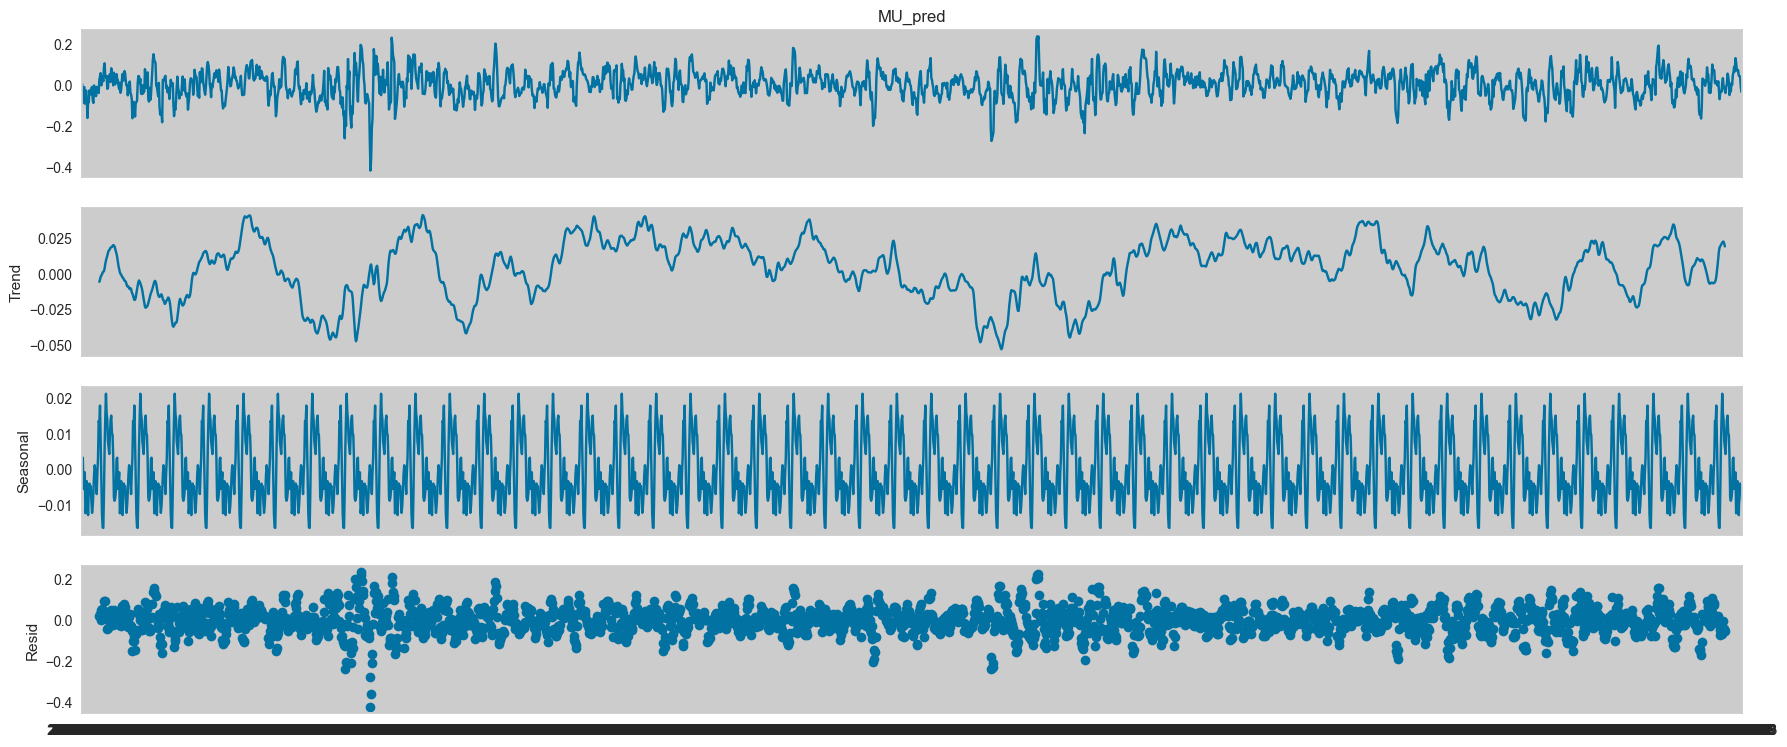

In [239]:
res = sm.tsa.seasonal_decompose(Y,period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(20)
pyplot.show()

### Evaluate Models

In [240]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=123)


In [277]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(["XGB", xgb.XGBRegressor()])
models.append(('SVR', SVR()))

In [278]:
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [279]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    ## k-fold analysis:
    kfold = KFold(n_splits=10)
    #converted mean squared error to positive. The lower the better
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring="neg_mean_squared_error")
    kfold_results.append(cv_results)
    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.004232 (0.000561) 0.004128 0.004480
LASSO: 0.004389 (0.000675) 0.004387 0.004545
EN: 0.004389 (0.000675) 0.004387 0.004545
KNN: 0.004844 (0.000770) 0.003199 0.005077
XGB: 0.003737 (0.000473) 0.000028 0.003491
SVR: 0.004371 (0.000682) 0.004260 0.004574
ABR: 0.004308 (0.000677) 0.003772 0.004451
GBR: 0.003953 (0.000631) 0.002568 0.004143
RFR: 0.003438 (0.000597) 0.000471 0.003334
ETR: 0.003198 (0.000537) 0.000005 0.003018


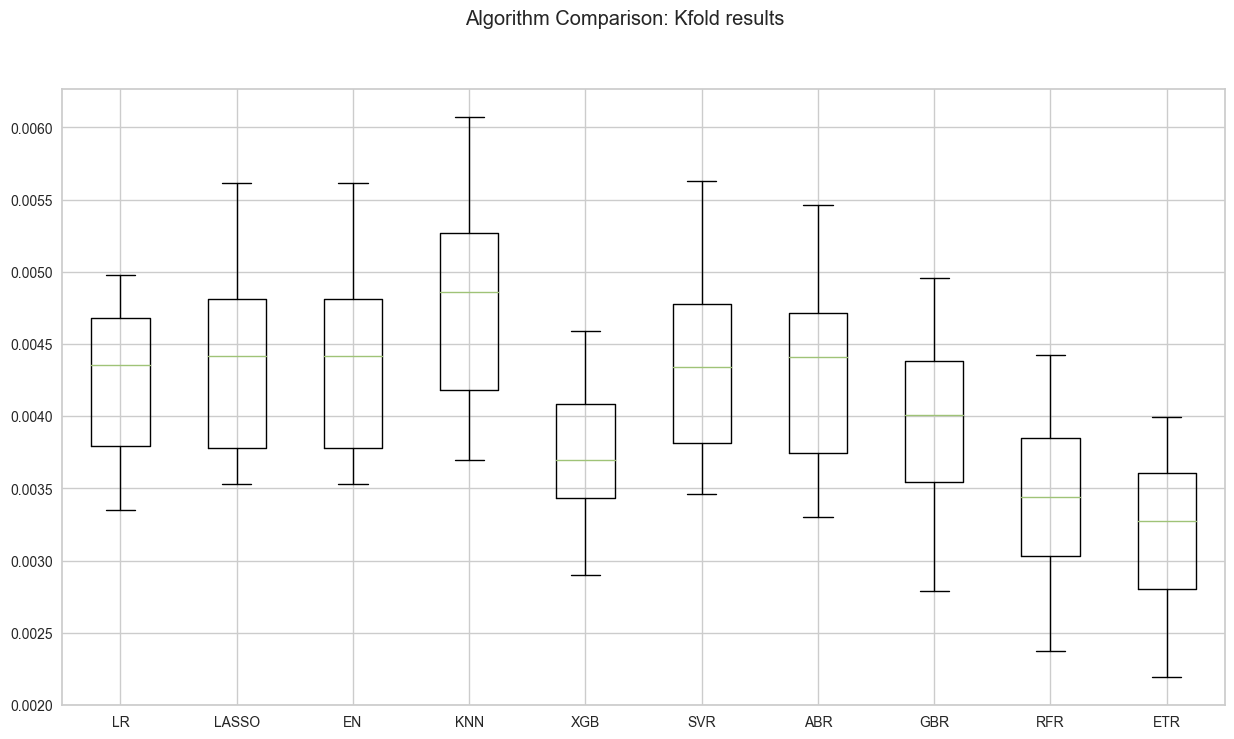

In [280]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

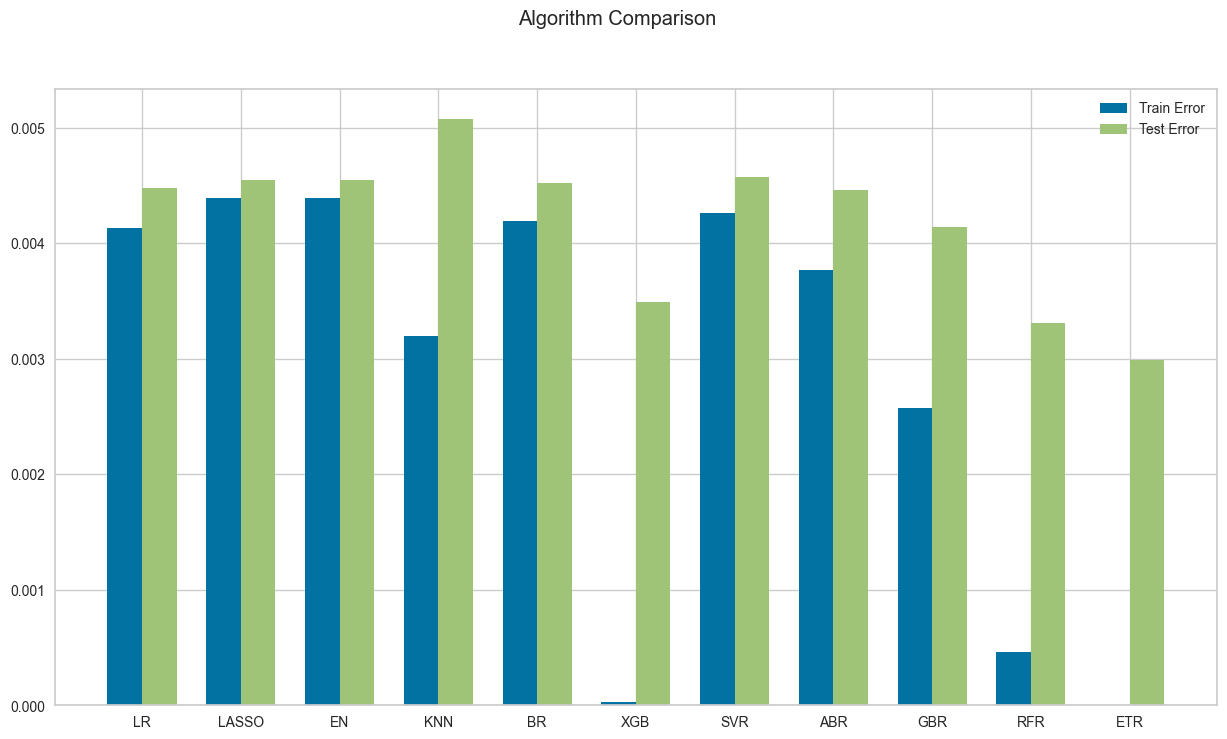

In [245]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

We can see that Bayesian Ridge Regression has a comparable error score to Lasso and Ensemble models.

In [246]:
X_train

,NVDA,AMD,WDC,STX,QCOM,QQQ,VGT,SOXX,^GSPC,^DJI,^IXIC,MU_DT,MU_3DT,MU_6DT,MU_12DT,MU_RSI,MU_MOM,MU_SMA,MU_ROC,MU_ADX
Date,,,,,,,,,,,,,,,,,,,,
2011-01-21,-0.051316,-0.091202,-0.038598,-0.058497,-0.012220,-0.016035,-0.011479,-0.018508,-0.000319,0.011858,-0.016867,0.021573,0.219593,0.214543,0.242642,77.301373,0.210000,8.515333,2.180686,45.730082
2010-09-23,0.094708,0.039846,0.009244,-0.018759,0.039249,0.017452,0.012168,0.001561,0.000151,0.006359,0.010293,-0.062475,-0.008955,-0.069492,-0.262249,38.456482,-0.430000,6.954667,-6.056336,19.892772
2013-08-14,0.029026,0.034624,0.073760,0.024151,0.026482,0.005090,0.012857,-0.004507,-0.003270,-0.008635,0.004168,0.070585,0.122602,0.035019,0.279171,73.635859,1.009999,13.551333,7.313535,50.975179
2014-01-02,0.002525,0.046641,0.001453,-0.009519,0.003826,-0.002060,-0.003155,0.001954,-0.000731,0.005110,-0.002976,-0.007360,-0.066095,0.115881,0.158237,46.690039,-0.160000,21.541667,-0.733272,25.411068
2013-05-30,0.015846,0.020001,0.054608,0.034952,-0.016228,0.004202,0.013328,0.027971,-0.000568,0.001133,0.008052,0.085102,0.149396,0.236052,0.308932,82.708286,0.970000,10.350000,8.882786,57.902170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-07-25,-0.035885,-0.018446,-0.001006,0.012004,-0.042324,0.006430,0.006476,-0.042992,0.000061,-0.008198,0.003920,0.008112,-0.009233,0.079694,0.246453,47.410408,0.269997,32.855333,0.814469,15.042804
2018-07-25,0.000675,-0.048642,-0.040806,-0.028988,0.011170,0.015934,0.015003,-0.012736,0.010757,0.008488,0.009857,-0.073292,0.036430,-0.125846,0.149417,30.761469,-4.060001,55.565000,-7.067017,32.555414
2017-01-09,0.005046,0.013141,0.055947,-0.003149,0.006878,0.031978,0.025515,0.012632,0.013342,0.006294,0.027249,0.018979,0.096251,0.115157,0.286191,56.676480,0.420000,20.868000,1.916059,19.299971


### Training the model with parameter grid

In [247]:

lr_pipe = Pipeline([("scaler", StandardScaler()), ("lr", LinearRegression())])
lr_params = {"lr__fit_intercept": [True, False]}

In [248]:
lr_grid = GridSearchCV(lr_pipe, lr_params)

lr_grid.fit(X_train, Y_train)
print('best parameters:', lr_grid.best_params_)
best_lr = lr_grid.best_estimator_

best parameters: {'lr__fit_intercept': True}


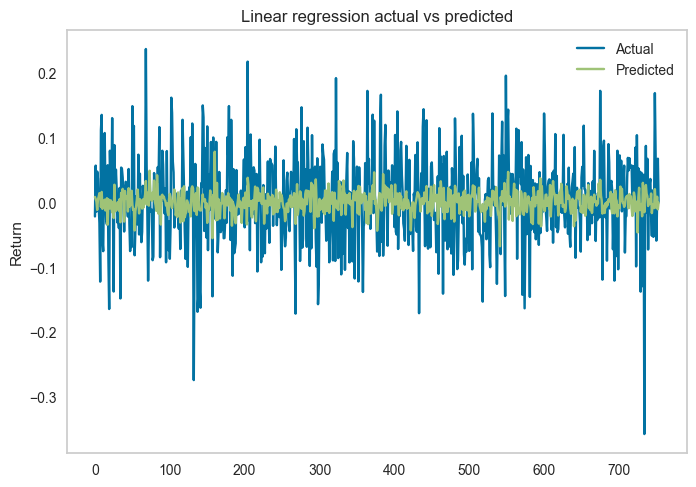

In [249]:
y_true = Y_test.to_numpy(copy=True)
y_pred = best_lr.predict(X_test)

pyplot.plot(y_true, label='Actual', color="b")
pyplot.plot(y_pred, label='Predicted', color="g")
pyplot.figsize=(10, 20)
pyplot.ylabel('Return')
pyplot.title('Linear regression actual vs predicted')
pyplot.grid()
pyplot.legend()
pyplot.show()

In [250]:
n_estimators  = [20, 50, 100]
max_depth = [1, 5, 10, 20, 50]
learning_rate = [0.1, 0.3, 0.5, 0.8]
booster = ['gbtree', 'gblinear', 'dart']
base_score = [0.2, 0.5 ,0.7]
xgb_grid = {'learning_rate': learning_rate,
            'booster': booster,
            'base_score': base_score}

In [251]:
xgb_reg = RandomizedSearchCV(xgb.XGBRegressor(verbosity=0), xgb_grid, n_iter=100)

xgb_reg.fit(X_train, Y_train)
print('best parameters:', xgb_reg.best_params_)
best_xgb = xgb_reg.best_estimator_

best parameters: {'learning_rate': 0.1, 'booster': 'gbtree', 'base_score': 0.5}


In [252]:
best_xgb = xgb.XGBRegressor(**best_xgb.get_params())

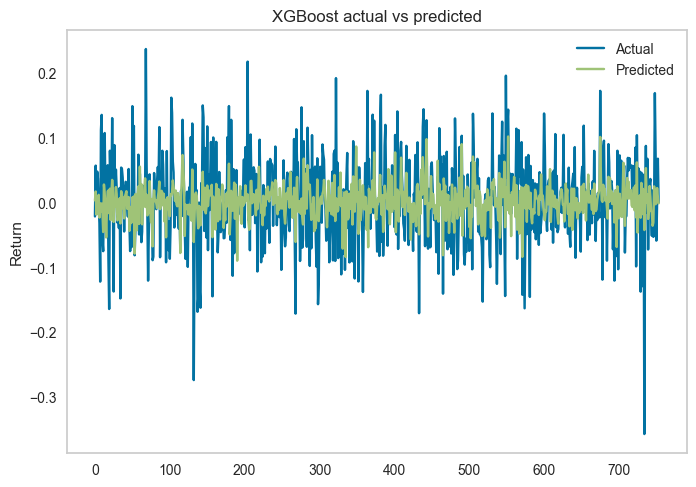

In [253]:
y_true = Y_test.to_numpy(copy=True)

best_xgb.fit(X_train, Y_train)
y_pred = best_xgb.predict(X_test)

pyplot.plot(y_true, label='Actual', color="b")
pyplot.plot(y_pred, label='Predicted', color="g")
pyplot.figsize=(10,20)
pyplot.ylabel('Return')
pyplot.title('XGBoost actual vs predicted')
pyplot.grid()
pyplot.legend()
pyplot.show()

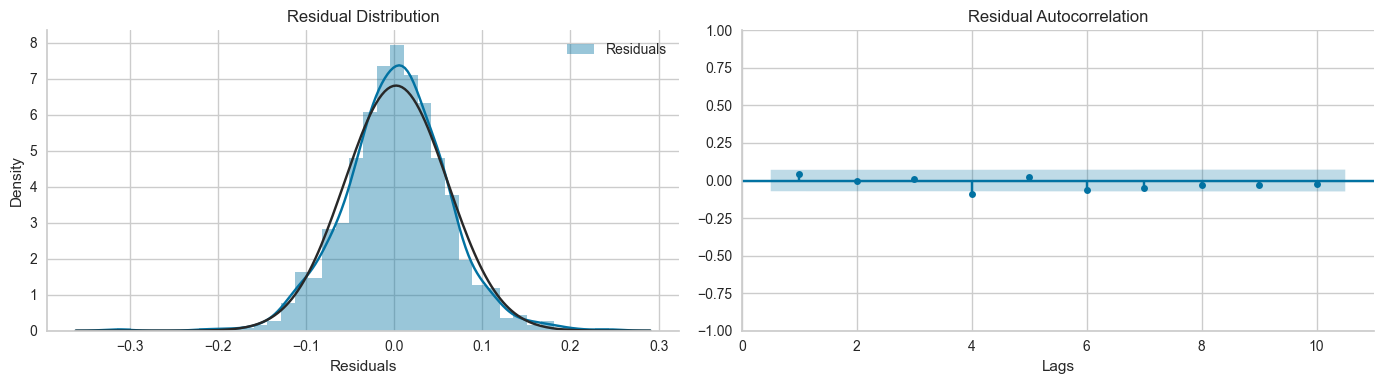

In [254]:
residuals = np.subtract(y_true, y_pred)

fig, axes = pyplot.subplots(ncols=2, figsize=(14,4))
sns.distplot(residuals, fit=norm, ax=axes[0], axlabel='Residuals', label='Residuals')
axes[0].set_title('Residual Distribution')
axes[0].legend()
plot_acf(residuals, lags=10, zero=False, ax=axes[1], title='Residual Autocorrelation')
axes[1].set_xlabel('Lags')
sns.despine()
fig.tight_layout()

In [275]:
cumret_predicted = np.cumsum(best_lr.predict(X)) 
cumret_actual = np.cumsum(Y) 

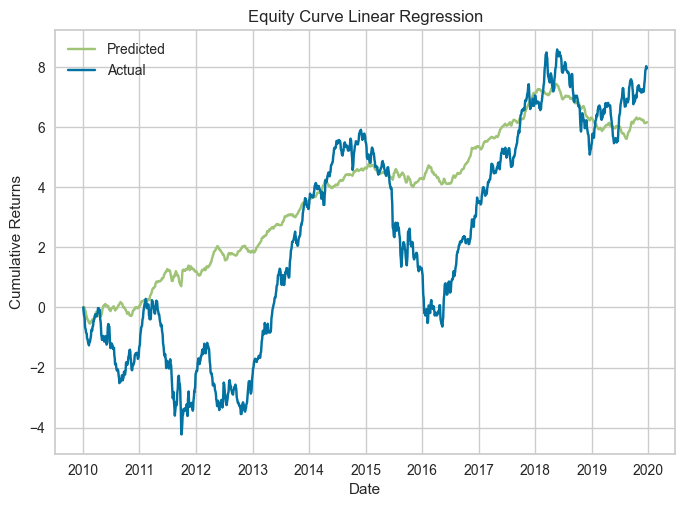

In [276]:

dates = pd.to_datetime(Y.index)
fig, ax = pyplot.subplots()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.plot(dates, cumret_predicted, label='Predicted', color="g")
ax.plot(dates, cumret_actual, label='Actual', color="b")

ax.set_title('Equity Curve Linear Regression')
ax.set_ylabel('Cumulative Returns')
ax.set_xlabel('Date')

pyplot.legend()
pyplot.show()

In [294]:
# positions = np.where(y_pred > 0, 1, -1 ) #POSITIONS
y_pred_test = best_xgb.predict(X_test)
cumret_predicted_test = np.cumsum(y_pred_test) 
rho, pval = spearmanr(Y_test, y_pred_test)
cagr = (1 + cumret_predicted_test[-1]) ** (252 / len(cumret_predicted_test)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret_predicted_test)
ratio = (252.0 ** (1.0/2.0)) * np.mean(y_pred_test) / np.std(y_pred_test)
print (('Out-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}  Rho={:0.6} PVal={:0.6}\n'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD, rho, pval))

Out-sample: CAGR=0.237105 Sharpe ratio=0.70887 maxDD=-0.45007 maxDDD=285 Calmar ratio=0.526817  Rho=0.509936 PVal=3.78546e-51



In [295]:
y_pred_train = best_xgb.predict(X_train)
cumret_predicted_train = np.cumsum(y_pred_train) 
rho, pval = spearmanr(Y_train, y_pred_train)
cagr = (1 + cumret_predicted_train[-1]) ** (252 / len(cumret_predicted_train)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret_predicted_train)
ratio = (252.0 ** (1.0/2.0)) * np.mean(y_pred_train) / np.std(y_pred_train)
print (('In-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}  Rho={:0.6} PVal={:0.6}\n'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD, rho, pval))

In-sample: CAGR=0.310662 Sharpe ratio=1.09155 maxDD=-0.426442 maxDDD=239 Calmar ratio=0.728497  Rho=0.949867 PVal=0.0



In [ ]:
cumret_predicted = np.cumsum(best_xgb.predict(X)) 
cumret_actual = np.cumsum(Y) 

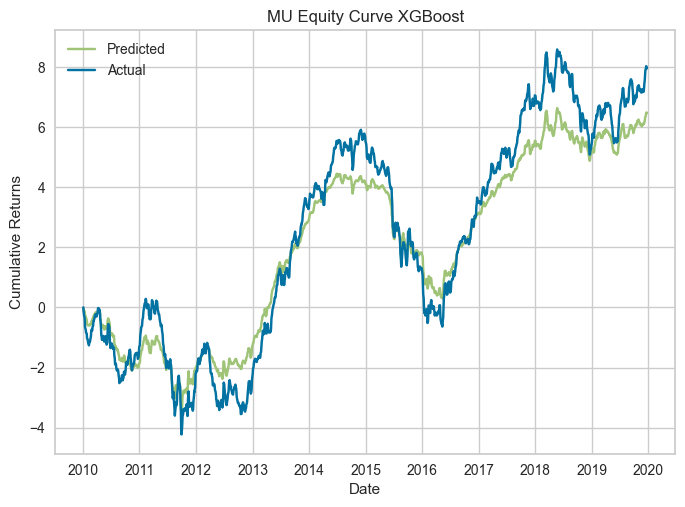

In [259]:

dates = pd.to_datetime(Y.index)
fig, ax = pyplot.subplots()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.plot(dates, cumret_predicted, label='Predicted', color="g")
ax.plot(dates, cumret_actual, label='Actual', color="b")

ax.set_title('MU Equity Curve XGBoost')
ax.set_ylabel('Cumulative Returns')
ax.set_xlabel('Date')

pyplot.legend()
pyplot.show()


average return 0.000133
[-0.00204442  0.00192405]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.4456


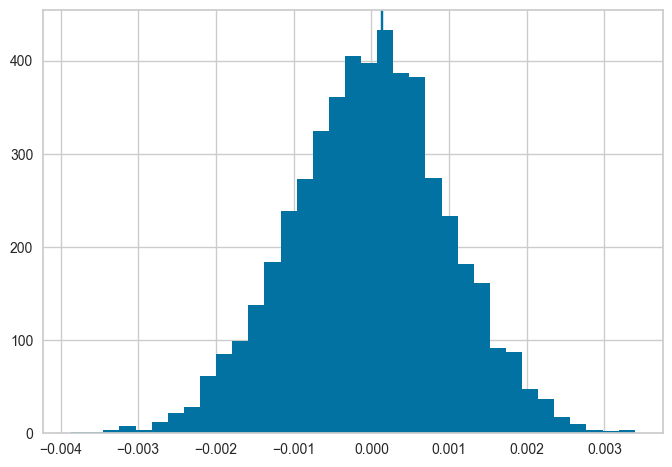

In [260]:
import WhiteRealityCheckFor1
#white reality check
positions = np.where(best_xgb.predict(X_test)> 0,1,-1 )
close = df_mapping["MU"]["Adj Close"]
detrended_close = detrendPrice.detrendPrice(close)
detrended_ret = np.log(detrended_close).diff(return_period).shift(-return_period).dropna()
detrended_syst_rets = detrended_ret * pd.Series(positions).shift(return_period).fillna(0)
WhiteRealityCheckFor1.bootstrap(detrended_syst_rets)
pyplot.show()

## Automated ML pipeline with PyCaret

In [261]:
exp_reg = RegressionExperiment()
reg = exp_reg.setup(dataset, target='MU_pred', index=False, train_size=0.7)

,Description,Value
0,Session id,8448
1,Target,MU_pred
2,Target type,Regression
3,Original data shape,"(2511, 16)"
4,Transformed data shape,"(2511, 16)"
5,Transformed train set shape,"(1757, 16)"
6,Transformed test set shape,"(754, 16)"
7,Numeric features,15
8,Preprocess,True
9,Imputation type,simple


In [262]:
best_reg = exp_reg.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0445,0.0035,0.0586,0.2009,0.0484,1.3089,0.1580
knn,K Neighbors Regressor,0.0457,0.0037,0.0605,0.1470,0.0457,1.7116,0.0070
rf,Random Forest Regressor,0.0467,0.0037,0.0609,0.1395,0.0503,1.3950,0.4930
gbr,Gradient Boosting Regressor,0.0494,0.0041,0.0634,0.0694,0.0527,1.4202,0.2210
lightgbm,Light Gradient Boosting Machine,0.0489,0.0041,0.0636,0.0606,0.0477,1.8901,0.3070
xgboost,Extreme Gradient Boosting,0.0493,0.0042,0.0647,0.0233,0.0468,1.9071,0.0710
ridge,Ridge Regression,0.0507,0.0043,0.0652,0.0125,0.0558,1.2938,0.0100
huber,Huber Regressor,0.0508,0.0043,0.0652,0.0110,0.0549,1.3896,0.0140
br,Bayesian Ridge,0.0508,0.0043,0.0653,0.0105,0.0559,1.2952,0.0060
lr,Linear Regression,0.0510,0.0043,0.0652,0.0105,0.0540,1.4283,0.3300


In [263]:
type(best_reg).__name__

'ExtraTreesRegressor'

In [298]:
reg_tuned, tuner = exp_reg.tune_model(best_reg, return_tuner=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0513,0.0041,0.0640,-0.0351,0.0591,0.9856
1,0.0503,0.0040,0.0635,-0.0004,0.0571,1.1646
2,0.0555,0.0051,0.0716,-0.0011,0.0641,1.0777
3,0.0557,0.0053,0.0730,-0.0076,0.0646,1.0939
4,0.0562,0.0061,0.0781,-0.0010,0.0689,1.1753
5,0.0474,0.0038,0.0615,-0.0028,0.0551,1.1059
6,0.0518,0.0043,0.0654,-0.0001,0.0590,1.0688
7,0.0455,0.0035,0.0590,-0.0002,0.0531,1.1302
8,0.0470,0.0036,0.0598,-0.0037,0.0545,1.0514


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [306]:
import pprint
pprint.pprint(tuner.param_distributions)

{'actual_estimator__bootstrap': [True, False],
 'actual_estimator__criterion': ['squared_error', 'absolute_error'],
 'actual_estimator__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 'actual_estimator__max_features': [1.0, 'sqrt', 'log2'],
 'actual_estimator__min_impurity_decrease': [0,
                                             0.0001,
                                             0.001,
                                             0.01,
                                             0.0002,
                                             0.002,
                                             0.02,
                                             0.0005,
                                             0.005,
                                             0.05,
                                             0.1,
                                             0.2,
                                             0.3,
                                             0.4,
                                         

In [ ]:
{'actual_estimator__bootstrap': [True, False],
 'actual_estimator__criterion': ['squared_error', 'absolute_error'],
 'actual_estimator__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 'actual_estimator__max_features': [1.0, 'sqrt', 'log2'],
 'actual_estimator__min_impurity_decrease': [0, 0.0001, 0.001,0.01, 0.0002, 0.002,0.02, 0.0005, 0.005,0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
 'actual_estimator__min_samples_leaf': [2, 3, 4, 5, 6],
 'actual_estimator__min_samples_split': [2, 5, 7, 9, 10],
 'actual_estimator__n_estimators': [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,
                                    160,170,180,190,200,210,220,230,240,250,260,270,280,290,300]}

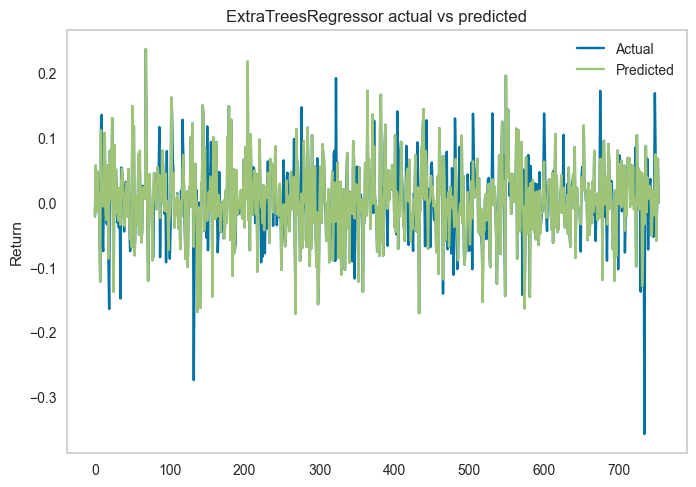

In [265]:
y_true = Y_test.to_numpy(copy=True)
y_pred = exp_reg.predict_model(best_reg, X_test)["prediction_label"]

pyplot.plot(y_true, label='Actual', color="b")
pyplot.plot(y_pred, label='Predicted', color="g")
pyplot.figsize=(10, 20)
pyplot.ylabel('Return')
pyplot.title(f'{type(best_reg).__name__} actual vs predicted')
pyplot.grid()
pyplot.legend()
pyplot.show()

In [266]:
predicted = exp_reg.predict_model(best_reg, X)["prediction_label"]
cumret_predicted = np.cumsum(predicted) 
cumret_actual = np.cumsum(Y) 

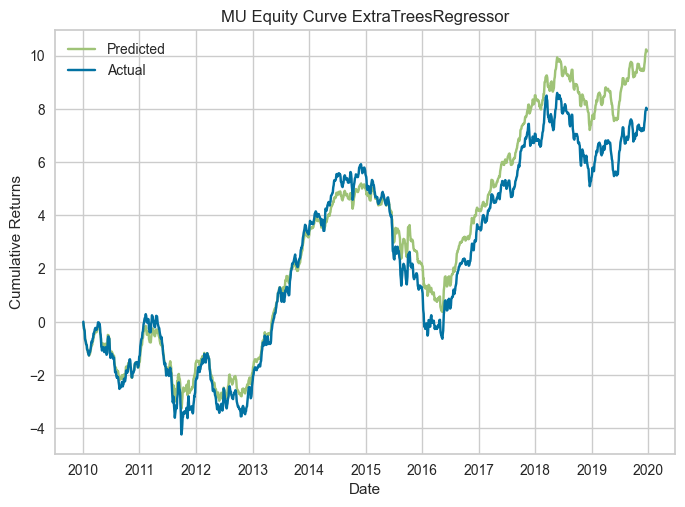

In [267]:
dates = pd.to_datetime(Y.index)
fig, ax = pyplot.subplots()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.plot(dates, cumret_predicted, label='Predicted', color="g")
ax.plot(dates, cumret_actual, label='Actual', color="b")

ax.set_title(f'MU Equity Curve {type(best_reg).__name__}')
ax.set_ylabel('Cumulative Returns')
ax.set_xlabel('Date')

pyplot.legend()
pyplot.show()

average return -0.000904
[-0.00193415  0.00193102]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.812


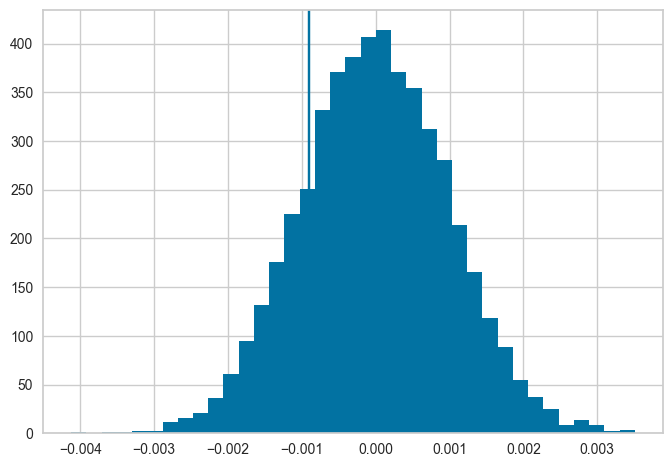

In [268]:
#white reality check
predicted_test = exp_reg.predict_model(best_reg, exp_reg.X_test)["prediction_label"]
positions = np.where(predicted_test > 0, 1, -1 )
close = df_mapping["MU"]["Adj Close"]
detrended_close = detrendPrice.detrendPrice(close)
detrended_ret = np.log(detrended_close).diff(return_period).shift(-return_period).dropna()
detrended_syst_rets = detrended_ret * pd.Series(positions).shift(return_period).fillna(0)
WhiteRealityCheckFor1.bootstrap(detrended_syst_rets)
pyplot.show()

In [269]:
exp_ts = TSForecastingExperiment()
dataset.index = pd.to_datetime(dataset.index)
ts_dataset = dataset.asfreq('D', method="ffill")
ts = exp_ts.setup(ts_dataset, target='MU_pred', numeric_imputation_target="mean")

,Description,Value
0,session_id,8011
1,Target,MU_pred
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(3641, 16)"
5,Transformed data shape,"(3641, 16)"
6,Transformed train set shape,"(3640, 16)"
7,Transformed test set shape,"(1, 16)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [270]:
best_ts = exp_ts.compare_models()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,TT (Sec)
auto_arima,Auto ARIMA,0.1413,0.0955,0.0048,0.0048,0.1405,0.1638,45.5333
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.2239,0.1514,0.0076,0.0076,0.2227,0.3198,0.0600
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.2301,0.1556,0.0078,0.0078,0.2288,0.3059,0.0400
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.2332,0.1577,0.0079,0.0079,0.2319,0.3036,0.2933
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,0.2443,0.1652,0.0083,0.0083,0.2429,0.3386,1.0533
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.2829,0.1913,0.0096,0.0096,0.2813,0.4597,0.7200
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.2837,0.1918,0.0096,0.0096,0.2821,0.4181,0.0767
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,0.3404,0.2302,0.0116,0.0116,0.3386,0.4478,0.2900
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,0.3492,0.2361,0.0119,0.0119,0.3473,0.4912,0.0667
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.3617,0.2446,0.0123,0.0123,0.3597,0.4816,0.2733


In [271]:
exp_ts.plot_model(best_ts, "insample", data_kwargs={"labels": ["Predicted"]})

In [272]:
pred = exp_ts.get_insample_predictions(best_ts)

In [273]:
cumret_predicted = np.cumsum(pred) 
cumret_actual = np.cumsum(ts_dataset["MU_pred"].iloc[:-1]) 

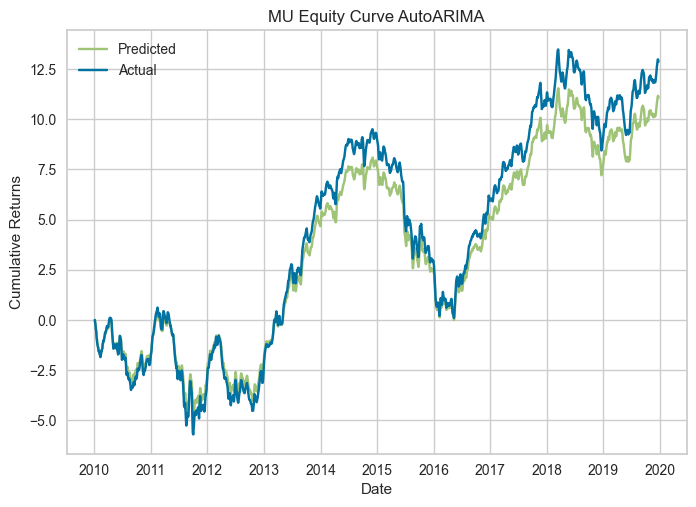

In [274]:
dates = pd.to_datetime(ts_dataset.iloc[:-1].index)
fig, ax = pyplot.subplots()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.plot(dates, cumret_predicted, label='Predicted', color="g")
ax.plot(dates, cumret_actual, label='Actual', color="b")

ax.set_title(f'MU Equity Curve {type(best_ts).__name__}')
ax.set_ylabel('Cumulative Returns')
ax.set_xlabel('Date')

pyplot.legend()
pyplot.show()